**Spotify Songs Clustering: By Thabo Pilusa**

In [1]:
#The usual, starting off with the necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

In [2]:

# Load your dataset
data_original = pd.read_csv('SpotifyFeatures.csv')
data = data_original.sample(frac=0.25, random_state=42)  #Reduce the dataset to just 25% to analyse on a low RAM device for people like us :(((

data.head() #print the first 5 rows of the dataset


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
788,Country,A Thousand Horses,My Time's Comin',16zol4GvHyTER5irYODUk0,45,0.00192,0.327,194107,0.8350,0.000150,C,0.1670,-4.952,Major,0.0609,171.795,4/4,0.3850
207109,Soundtrack,Mark Mothersbaugh,House Tour,6ac5gUfGTckpdGQCyWsdh2,25,0.93200,0.253,102920,0.0798,0.568000,C,0.0906,-18.512,Major,0.0439,110.931,4/4,0.0487
138644,Reggae,Unified Highway,We Can't Fall (Remix) [feat. J. Patz],09Yz6koF1Y15n1012t1UX6,19,0.03310,0.821,225437,0.7370,0.013400,E,0.1320,-6.295,Minor,0.2120,137.968,4/4,0.7870
37164,Electronic,Stooki Sound,Endz - Original Mix,3dzEZARDL4ZwICMKVta7Xn,29,0.00428,0.745,225400,0.7720,0.114000,E,0.0722,-3.949,Major,0.0904,133.113,4/4,0.1700
174351,Comedy,Bill Hicks,I Love My Job (Live),39Z1G5384UgGa5vmW6WyxC,17,0.96500,0.502,287973,0.8040,0.000096,G,0.9020,-9.935,Major,0.8070,104.576,3/4,0.1850


**Select some features to work with**

In [3]:
features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
            'instrumentalness', 'liveness', 'valence', 'tempo']

In [4]:
# Scale the features for uniformity
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features])

# Convert scaled data into a DataFrame
scaled_df = pd.DataFrame(data_scaled, columns=features)

**Exploratory Data Analysis**

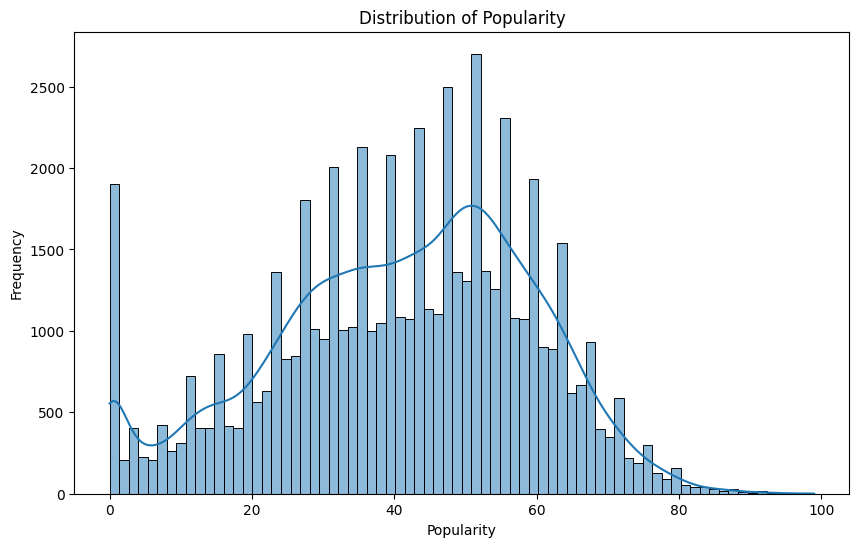

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(data['popularity'], kde=True)
plt.title('Distribution of Popularity')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

**The Correlation matrix for the features**

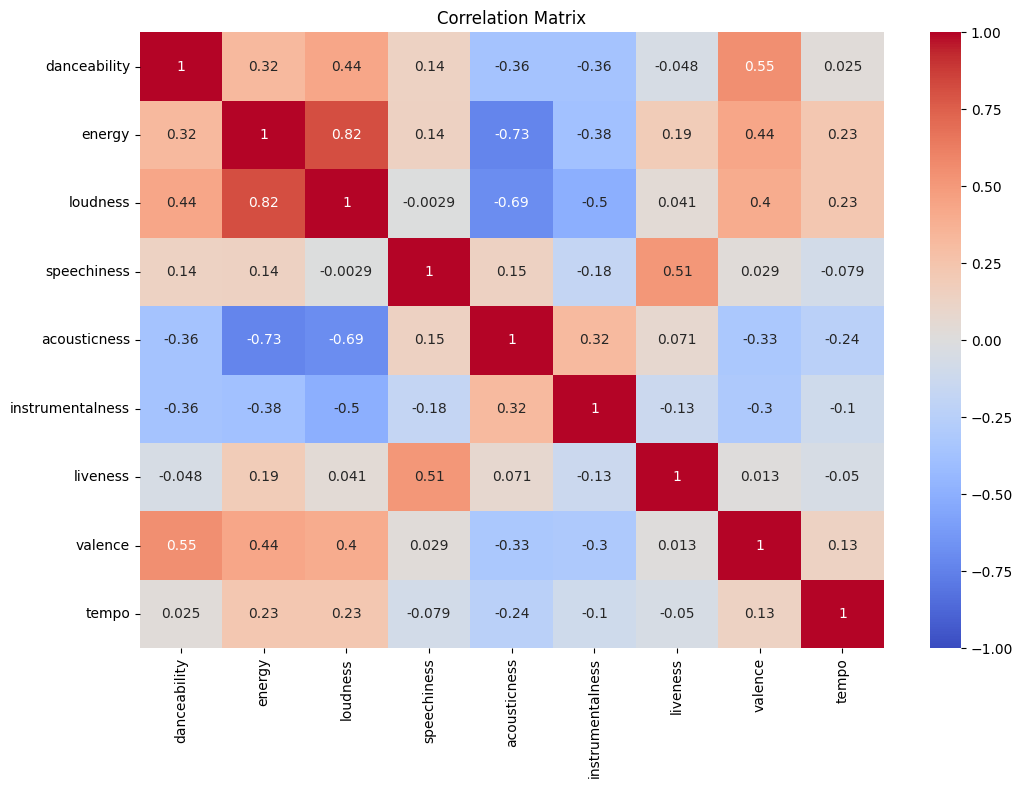

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(data[features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

**Clustering Method 1: K-Means Clustering**



- Finding the optimal k using the Elbow Method.
- The elbow method is a visual technique used to determine the optimal number of clusters (k) in k-means clustering by plotting the within-cluster sum of squares (WCSS) against the number of clusters and identifying the "elbow" point where the rate of decrease in WCSS starts to slow down.

- Sum of Squared Errors (SSE) measures the total variation within each cluster, helping evaluate the quality of cluster assignments and determine the optimal number of clusters.
-

In [7]:
!pip install kneed

Optimal k =  4


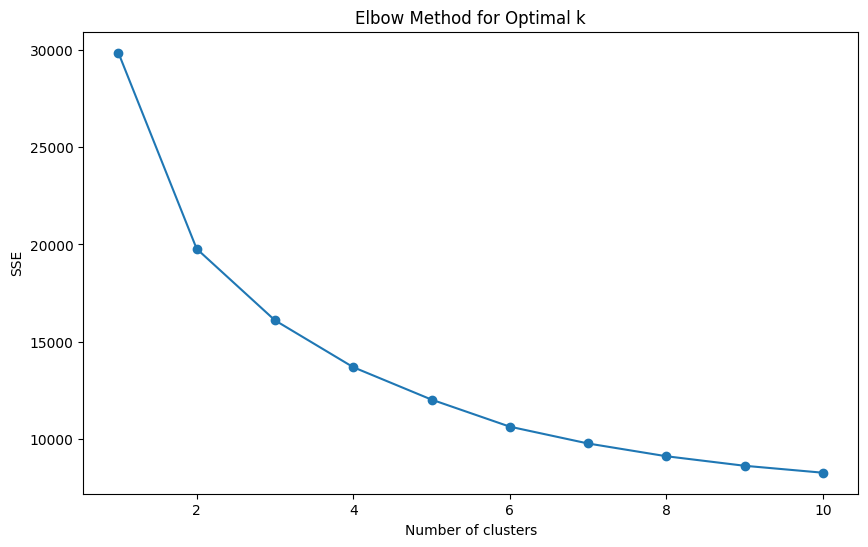

In [8]:
k_range = range(1, 11)
sse = []  # Initialize sse as an empty list
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)
from kneed import KneeLocator # This line imports the KneeLocator class from the kneed library
kl = KneeLocator(k_range, sse, curve="convex", direction="decreasing")
print("Optimal k = ", kl.elbow)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal k')
plt.show()

In [9]:
kmeans = KMeans(n_clusters= 4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(data_scaled)
data['Cluster_KMeans'] = kmeans_labels

** Clustering Method 2: Hierarchical Clustering:** Needs high RAM to run large datasets like this one, so I commented it out, only undo that if running on a high RAM computer or cloud

- Hierarchical clustering groups data points into a hierarchy of clusters, visualized as a tree-like structure (dendrogram), where similar data points are grouped together and then progressively merged into larger clusters.


In [10]:
"""
linked = linkage(data_scaled, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=12)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()
"""

"\nlinked = linkage(data_scaled, method='ward')\nplt.figure(figsize=(10, 7))\ndendrogram(linked, truncate_mode='lastp', p=12)\nplt.title('Dendrogram for Hierarchical Clustering')\nplt.xlabel('Sample Index')\nplt.ylabel('Distance')\nplt.show()\n"

**Clustering Method 3: DBSCAN Clustering**

*  DBSCAN, or Density-Based Spatial Clustering of Applications with Noise, is a clustering algorithm that groups closely packed data points, identifies outliers, and can discover clusters of arbitrary shapes without needing to specify the number of clusters in advance.




In [11]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)
data['Cluster_DBSCAN'] = dbscan_labels

**Evaluating Clustering Performance**

- Silhouette score is a method of interpretation and validation of consistency within clusters of data.

In [12]:
silhouette_kmeans = silhouette_score(data_scaled, kmeans_labels)
#silhouette_hierarchical = silhouette_score(data_scaled, hierarchical_labels - 1)
silhouette_dbscan = silhouette_score(data_scaled, dbscan_labels) if len(set(dbscan_labels)) > 1 else 'N/A'


print(f'Silhouette Score for K-Means: {silhouette_kmeans}')
#print(f'Silhouette Score for Hierarchical Clustering: {silhouette_hierarchical}')
print(f'Silhouette Score for DBSCAN: {silhouette_dbscan}')

Silhouette Score for K-Means: 0.33810429700710837
Silhouette Score for DBSCAN: 0.29480393018444845


**PCA**

- Principal component analysis, or PCA, reduces the number of dimensions in large datasets to principal components that retain most of the original information.

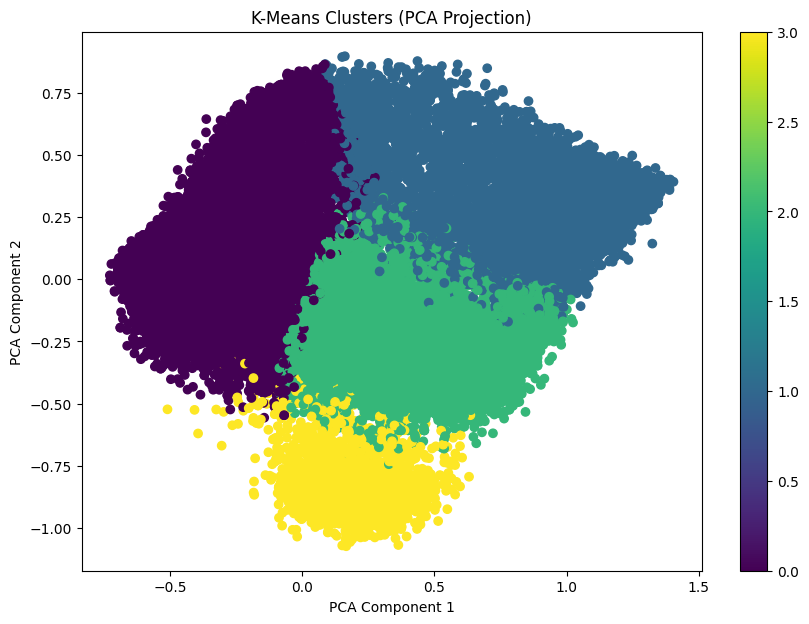

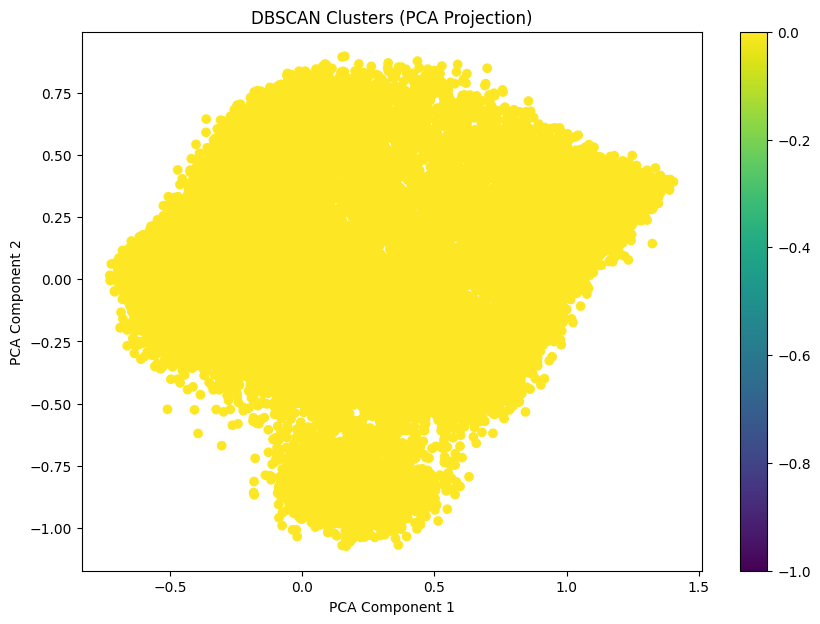

In [14]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title('K-Means Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

"""
plt.figure(figsize=(10, 7))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=hierarchical_labels - 1, cmap='plasma', marker='o')
plt.title('Hierarchical Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()
"""

plt.figure(figsize=(10, 7))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=dbscan_labels, cmap='viridis', marker='o')
plt.title('DBSCAN Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()